In [2]:
import numpy as np
import matplotlib.pyplot as plt
from compcolor import Combcol
import skimage.io
from IPython.display import HTML

from celluloid import Camera

## Image import
Here I'm simply using a 5D sample image form Fiji. We are working with a multi-channel image in 2D here, so here we just project each z-stack. We also scale the image to have values between 0 and 1.

In [3]:
#load an image, project along Z and scale intensity
image = skimage.io.imread('Data/mitosis.tif')
im_proj = np.mean(image,axis = 1)
im_proj = skimage.exposure.rescale_intensity(im_proj, out_range=(0,1))

## Creating a simple RGB movie
If one is happy to use RGB colors, it is very straightforward to create a movie: at each frame, one has just to create an NxNx3 array, each layer containing one channel that is going to be assigned the colors Red, Green, Blue.

We use the ```celluloid``` package which makes producing movies simpler, but in prinicple Matplotlib is sufficient.

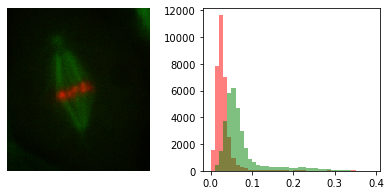

In [6]:
from matplotlib.animation import FFMpegWriter

colors = ['Red','Green']
moviewriter = FFMpegWriter(fps=15)
fig, axes = plt.subplots(1,2,figsize = (7,3))
with moviewriter.saving(fig, 'RGBmovie.mp4', dpi=100):
    for t in range(10):#range(im_proj.shape[0]):

        axes[1].cla()
        #create multi-channel iamge
        newim = np.stack((im_proj[t,0,:,:],im_proj[t,1,:,:],
                          np.zeros(im_proj[0,1,:,:].shape)),axis = 2)
        #show image and histogram
        axes[0].imshow(newim)
        for c in range(2):
            axes[1].hist(np.ravel(im_proj[t,c,:,:]),color = colors[c],alpha = 0.5,
                    bins = np.arange(0,0.4,0.01))
        axes[0].set_axis_off()
        moviewriter.grab_frame()

And here is the movie! We can look at it in the notebook directly or export it as a mov. file

In [9]:
HTML('<div align="middle"><video width="80%" controls><source src="RGBmovie.mp4" type="video/mp4"></video></div>')

## Other colormaps aka LUTs

The situation is slightly more complicated if we want to show the image in other colors. While Fiji is very good at dealing with this case, there is to my knowledge no one-liner for this in regular scientific Python. It is howver really not very difficult to do. Our goal here is to obtain a results similat to one we could have in Fiji. 

### Creating color maps

While Matplotlib offers many colormaps, unfortunately (and somewhat surprisingly) it doesn't seem to offer the simple colormaps going from black to a given saturated color (e.g. the 'Reds' colormap goes from white to red.). So let's just create them!

We know how Red is encoded in RGB: ```[1,0,0]```. If we want an 8-bit scale progressing for from black (```[0,0,0]```) to red, we can therefore just create a list of length 256 ```[0,0,0], [1/255,0,0], [2/255,0,0],...,[255/255,0,0]```:

In [12]:
red_map = [[i/255,0,0] for i in range(256)]
red_map[0:10]

[[0.0, 0, 0],
 [0.00392156862745098, 0, 0],
 [0.00784313725490196, 0, 0],
 [0.011764705882352941, 0, 0],
 [0.01568627450980392, 0, 0],
 [0.0196078431372549, 0, 0],
 [0.023529411764705882, 0, 0],
 [0.027450980392156862, 0, 0],
 [0.03137254901960784, 0, 0],
 [0.03529411764705882, 0, 0]]

Then we create colormap object that Matplotlib can understand by using the ```ListedColormap``` object:

In [13]:
from matplotlib.colors import ListedColormap

In [14]:
red_matplotlib_map = ListedColormap(red_map, 'Red')

We can even visualize our colormap using the ```colorbar``` module:

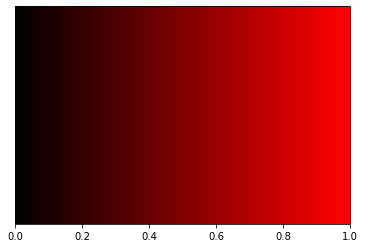

In [15]:
import matplotlib.colorbar
fig, ax = plt.subplots()
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=red_matplotlib_map, orientation='horizontal')

Now we can use this colormap to transform a simple NxN 2D image into a NxNx4 array with the correct values to render as an RGBA image:

In [16]:
coloured_image = red_matplotlib_map(im_proj[0,1,:,:])

In [17]:
coloured_image.shape

(196, 171, 4)

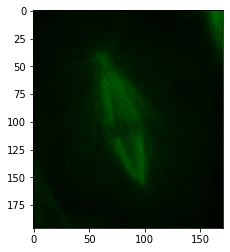

In [21]:
plt.imshow(coloured_image);

Of course we can repeat this with other colormaps, for example green:

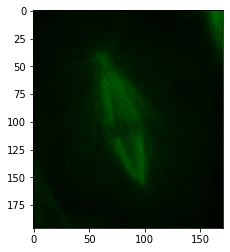

In [20]:
green_map = [[0,i/255,0] for i in range(256)]
green_matplotlib_map = ListedColormap(green_map, 'Green')
coloured_image = green_matplotlib_map(im_proj[0,1,:,:])
plt.imshow(coloured_image);

But this works for any colormap as long as we know how to construct it. For example for cyan whose RGB code is ```[0,1,1]```, we would have:

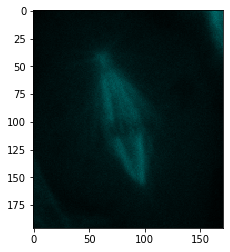

In [22]:
cyan_map = [[0,i/255,i/255] for i in range(256)]
cyan_matplotlib_map = ListedColormap(cyan_map, 'Cyan')
coloured_image = cyan_matplotlib_map(im_proj[0,1,:,:])
plt.imshow(coloured_image);

### Combining colormaps
Another thing that Fiji handles very well is the display of composite colors. There are many ways of showing multiple overlayed channels. It seems that Fiji handles this very simply by simply doing a maximum projection for each channel of each image. In the case where we use red, green, blue, this comes back to just composing an RGB image using each channel. However if we have a colormap such as Cyan, the projection allows to correctly "mix" the different channels.

We first create a red and a cyan image for the two channels that we have in this example:

In [28]:
channel1 = red_matplotlib_map(im_proj[0,0,:,:])
channel2 = cyan_matplotlib_map(im_proj[0,1,:,:])

Then we assemble them into a 4D stack:

In [29]:
assembled = np.stack((channel1, channel2), axis = 3)

In [30]:
assembled.shape

(196, 171, 4, 2)

Finally we project the data along this last axis to create our mixe-color image:

In [31]:
rgb_proj = np.max(assembled, axis = 3)

And we can visualize it:

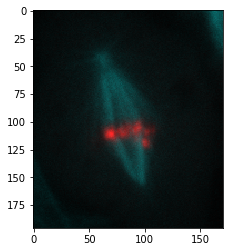

In [32]:
plt.imshow(rgb_proj)

### Making the movie

Now that we know how to define colormapas (LUTs) we can simply use them to make again a movie:

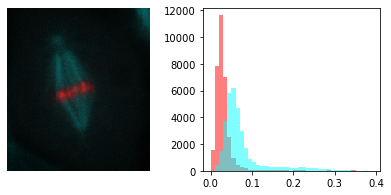

In [34]:
colors = ['Red','Cyan']
moviewriter = FFMpegWriter(fps=15)
fig, axes = plt.subplots(1,2,figsize = (7,3))
with moviewriter.saving(fig, 'red_cyan_movie.mp4', dpi=100):
    for t in range(10):#range(im_proj.shape[0]):

        axes[1].cla()
        #create multi-channel iamge
        channel1 = red_matplotlib_map(im_proj[t,0,:,:])
        channel2 = cyan_matplotlib_map(im_proj[t,1,:,:])
        assembled = np.stack((channel1, channel2), axis = 3)
        newim = np.max(assembled, axis = 3)        
        #show image and histogram
        axes[0].imshow(newim)
        for c in range(2):
            axes[1].hist(np.ravel(im_proj[t,c,:,:]),color = colors[c],alpha = 0.5,
                    bins = np.arange(0,0.4,0.01))
        axes[0].set_axis_off()
        moviewriter.grab_frame()

In [35]:
HTML('<div align="middle"><video width="80%" controls><source src="red_cyan_movie.mp4" type="video/mp4"></video></div>')